"""
Created Date:       15/8/2022
Last update:        13/3/2023
Program:            Frailty risk prediction model project in Community-dwelling Older adults in Northern Thailand
@author:            Natthanaphop Isaradech, MD.
Description:        -
"""

# Listing Contents
"""
There are 5 parts in this program:
    Part1: Tool and library import
    
    Part2: Variables import from dataframe
        2.1 Option "Dealing with unbalance data SMOTE: The synthetic minority oversampling technique"
        2.2 Choosing data for learning (sm or cc or normal)
        
    Part3: Generate model            
    Part4: Run classifier with cross-validation and plot ROC curves
    Part5: Confusion matrix and other performance matrix
"""

# Part1: Tool and library import
    # Common tool

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pickle
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
    # Model Package
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

    # Hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

    # Performance metrics
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score ,f1_score, roc_auc_score, auc ,plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay

# Part2: Variables import from dataframe

In [3]:
df = pd.read_excel('/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/Result/internal_dataset.xlsx')

selected_features = ['age','sex','stat','HT','lipid','BMI','waistcir','calfcir','exhaustion']

df['edu'] =np.where(df['education']>=4 , 1,0)
df['frail'] =np.where(df['frailscore']>=3 , 1,0)
df['stat'] =np.where(df['status']>=4 , 1,0)

pd.options.display.max_columns = df.shape[1]
df = df.dropna(axis = 0, how = 'any')
df.info()
df.describe()
#list_col = df.columns.tolist()[1:36]
#print(list_col)
#df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  2227 non-null   int64  
 1   Unnamed: 0    2227 non-null   int64  
 2   age           2227 non-null   int64  
 3   sex           2227 non-null   int64  
 4   status        2227 non-null   int64  
 5   education     2227 non-null   int64  
 6   DM            2227 non-null   int64  
 7   HT            2227 non-null   int64  
 8   Heart         2227 non-null   int64  
 9   COPD          2227 non-null   int64  
 10  Stroke        2227 non-null   int64  
 11  lipid         2227 non-null   int64  
 12  gouty         2227 non-null   int64  
 13  CKD           2227 non-null   int64  
 14  BMI           2227 non-null   float64
 15  waistcir      2227 non-null   float64
 16  calfcir       2227 non-null   float64
 17  midarm        2227 non-null   float64
 18  walktimemin   2227 non-null 

,Unnamed: 0.1,Unnamed: 0,age,sex,status,education,DM,HT,Heart,COPD,Stroke,lipid,gouty,CKD,BMI,waistcir,calfcir,midarm,walktimemin,exhaustion,PAwho,gripkg,frailscore,frail,edu,stat
count,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000
mean,1113.000000,1113.183655,70.964077,1.295465,2.357881,1.290525,0.162101,0.452627,0.043107,0.032780,0.008083,0.196677,0.025146,0.017961,32.635652,83.396363,32.403502,26.471576,6.416579,0.097890,0.163000,19.645676,1.290076,0.172878,0.063763,0.030085
std,643.023846,643.283648,7.492887,0.456354,0.658679,0.945750,0.368627,0.497863,0.203144,0.178099,0.089559,0.397575,0.156603,0.132841,7.397364,11.226877,4.350002,3.493263,2.011043,0.297232,0.369448,6.683643,1.247929,0.378227,0.244385,0.170860
min,0.000000,0.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.714558,0.000000,15.500000,13.000000,1.000000,0.000000,0.000000,3.200000,0.000000,0.000000,0.000000,0.000000
25%,556.500000,556.500000,65.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.551493,77.000000,30.000000,24.000000,5.135000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
50%,1113.000000,1113.000000,70.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.108108,83.000000,32.000000,26.000000,6.000000,0.000000,0.000000,18.900000,1.000000,0.000000,0.000000,0.000000
75%,1669.500000,1669.500000,77.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.537879,91.000000,35.000000,28.000000,7.060000,0.000000,0.000000,23.400000,2.000000,0.000000,0.000000,0.000000
max,2226.000000,2227.000000,93.000000,2.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.206897,124.000000,93.000000,40.000000,25.700000,1.000000,1.000000,57.250000,5.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         2227 non-null   int64  
 1   sex         2227 non-null   int64  
 2   stat        2227 non-null   int64  
 3   HT          2227 non-null   int64  
 4   lipid       2227 non-null   int64  
 5   BMI         2227 non-null   float64
 6   waistcir    2227 non-null   float64
 7   calfcir     2227 non-null   float64
 8   exhaustion  2227 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 156.7 KB


'\nSex: 1 = male, 2 = Female\nStatus: 0 = Not living alone, 1 = living alone\n'

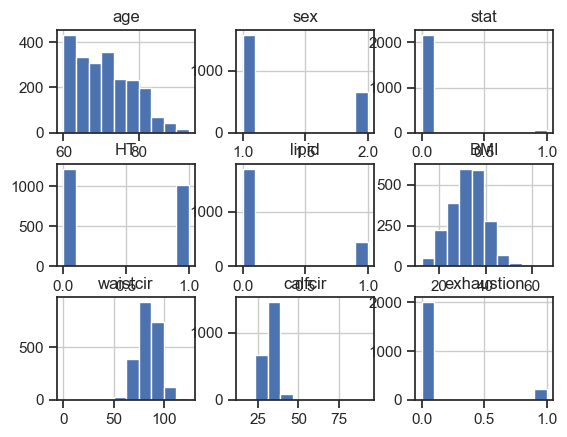

In [4]:
## X Feature Selection 
X = df[selected_features]
#X = transformer.fit_transform(X)
X.info()
X.hist()

"""
Sex: 1 = male, 2 = Female
Status: 0 = Not living alone, 1 = living alone
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   frail   2227 non-null   int64
dtypes: int64(1)
memory usage: 17.5 KB


array([[<AxesSubplot: title={'center': 'frail'}>]], dtype=object)

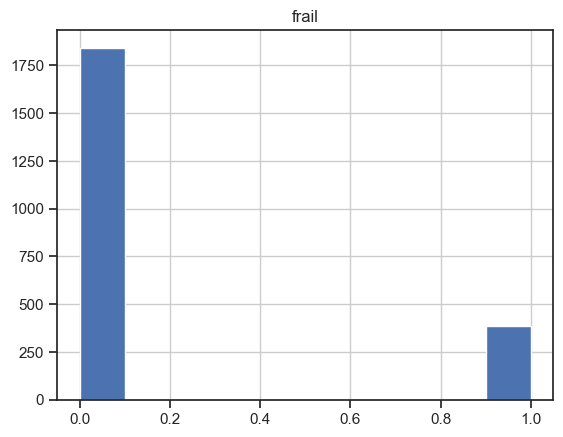

In [5]:
    ## Y Selection
y = df[['frail']]
y.info()
y.hist()

## Dealing with Unbalance data SMOTE

In [6]:
# 2.1 Option "Dealing with unbalance data SMOTE: The synthetic minority oversampling technique"
## Oversampling
sm = SMOTE(random_state=42)
X_sm, Y_sm = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(Y_sm))

## Undersampling 
cc = RandomUnderSampler(random_state=42)
X_cc, Y_cc = cc.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(Y_cc))

# 2.2 Choosing data for learning (sm or cc or normal)
X = np.array(X_sm)
y = np.array(Y_sm)

print("Resampled dataset count:" + str(len(y)))
#X = np.array(X_cc)
#Y = np.array(Y_cc)

#X = np.array(X)
#Y = np.array(Y)

Resampled dataset shape Counter({'frail': 1})
Resampled dataset shape Counter({'frail': 1})
Resampled dataset count:3684


# Part3: Generating Model 
The hyperparameters were determined by using a grid search via the GridSearch CV package with 10-fold cross-validation on the derived dataset to determine the parameters of each model that led to the best discriminative performance. 

In [7]:
## Create the parameter grid based on the results of random search 

logista_GS = LogisticRegression(**{'C': 2, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'})
knn_GS = KNeighborsClassifier(**{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'})
rng_forest_GS = RandomForestClassifier(**{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 2, 'max_features': 8, 'n_estimators': 100})
mlp_GS = MLPClassifier(**{'activation': 'tanh', 'hidden_layer_sizes': 90, 'learning_rate': 'invscaling', 'solver': 'adam'})
gbc_GS = GradientBoostingClassifier(**{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 1, 'max_features': 'sqrt', 'min_weight_fraction_leaf': 0.0, 'n_estimators': 8, 'subsample': 1})
svm_GS = LinearSVC(**{'C': 1, 'dual': False, 'loss': 'hinge', 'multi_class': 'crammer_singer', 'penalty': 'l1'})

# Part4: Internal Validation dataset - Run classifier with cross-validation and plot ROC curves

In [8]:
def roc_curve(model, model_name):
        """
        roc_curve function used for cross-valitaion and plot ROC curves
        *Agr
        model: (var) trained model with best parameters
        model_name: (str) name of the model
        """
        cv = StratifiedKFold(n_splits=10)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        fig, ax = plt.subplots()
        for i, (train, test) in enumerate(cv.split(X,y)):
                model.fit(X[train], y[train].ravel())
                viz = RocCurveDisplay.from_estimator(model, X[test], y[test],
                                        name='ROC fold {}'.format(i),
                                        alpha=0.5, lw=1, ax=ax)
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        ci_auc = sms.DescrStatsW(aucs).tconfint_mean()
        ax.plot(mean_fpr, mean_tpr, color='b',
                label='Mean ROC,[95% CI]'+': %0.2f, [%0.2f - %0.2f]' % (mean_auc, ci_auc[0], ci_auc[1]),
                lw=2, alpha=.8)

        ci_tpr = sms.DescrStatsW(tprs).tconfint_mean()
        tprs_upper = np.minimum(ci_tpr[1], 1)
        tprs_lower = np.maximum(ci_tpr[0], 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label= '95% CI')
        ax.set_xlabel("1 - Specificity")
        ax.set_ylabel("Sensitivity")
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver Operating Characteristic of " + str(model_name) + " using Rebalanced Data by SMOTE")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
#plot_roc_curve


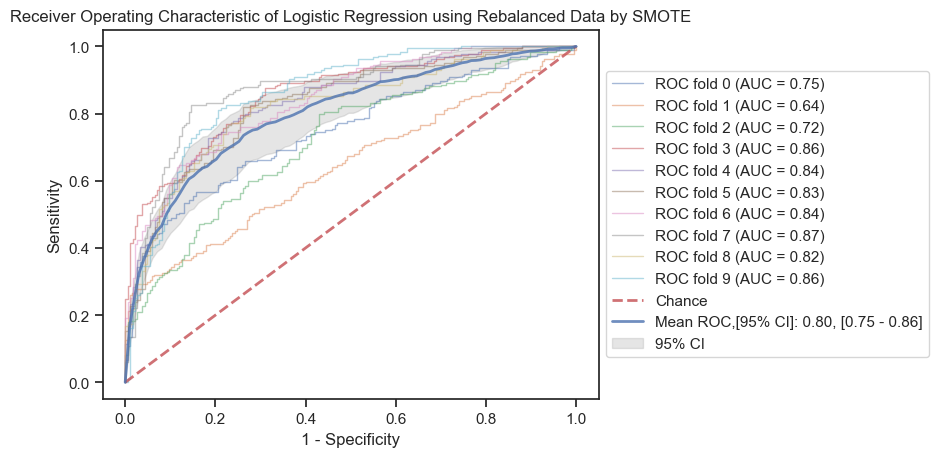

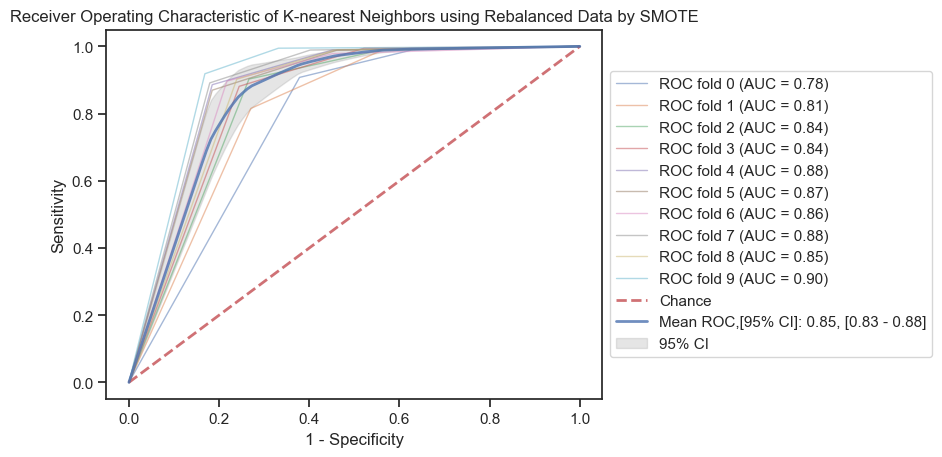

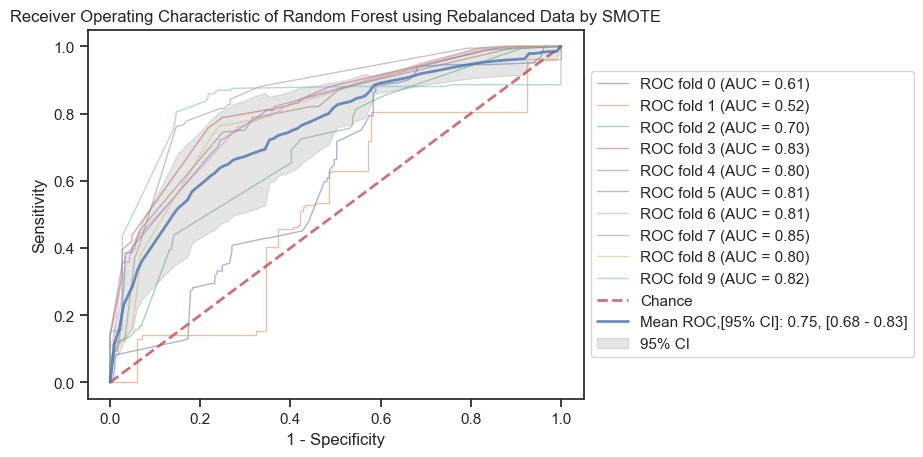

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


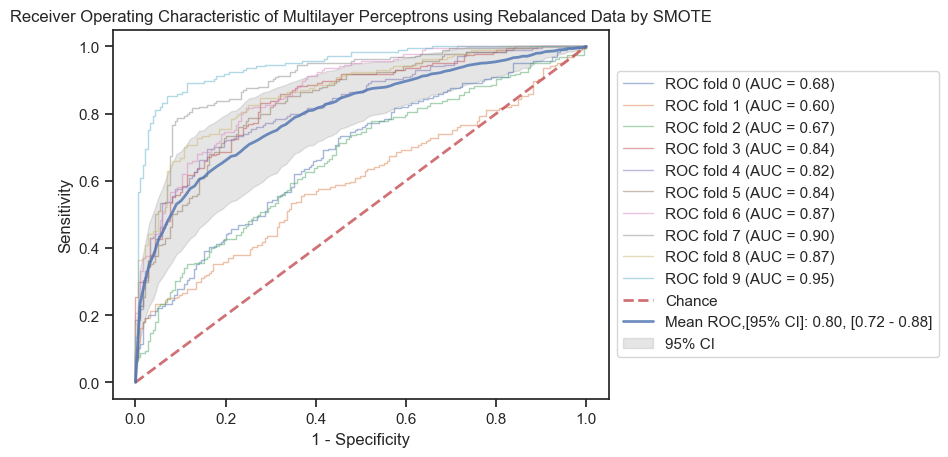

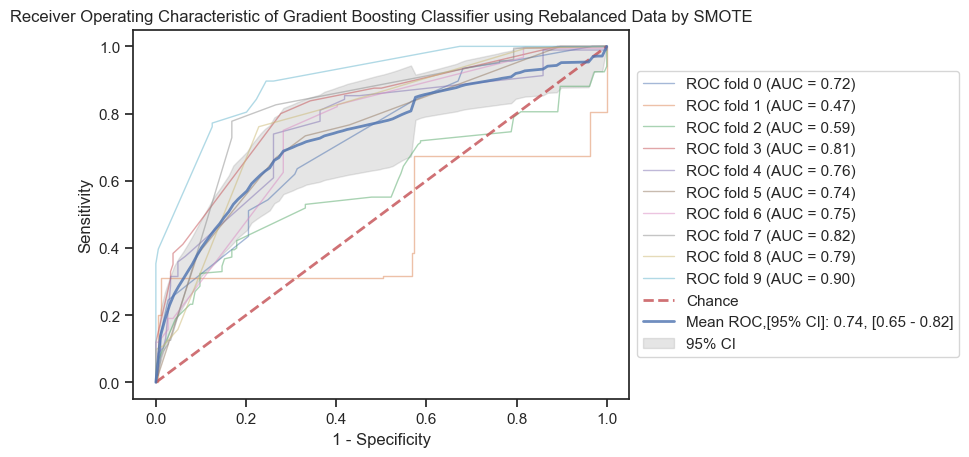

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopi

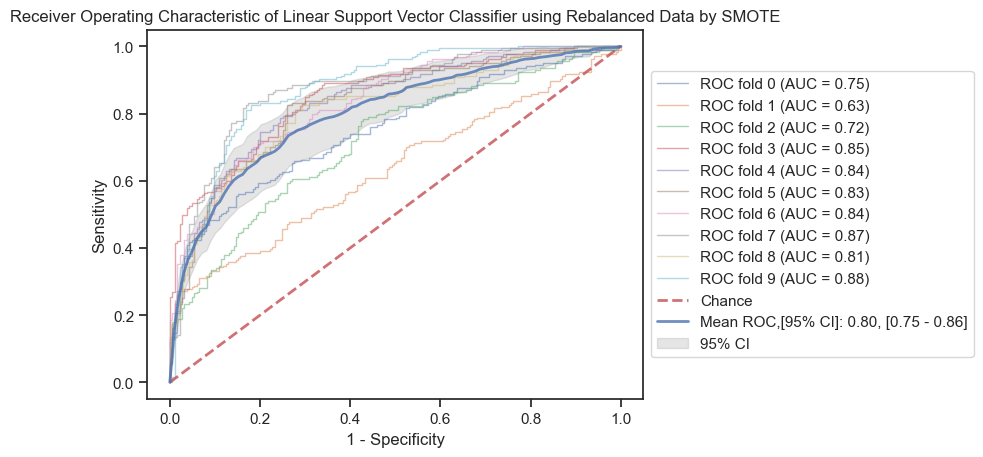

In [9]:
###AuROC Report
roc_curve(logista_GS, "Logistic Regression")
roc_curve(knn_GS, "K-nearest Neighbors")
roc_curve(rng_forest_GS, "Random Forest")
roc_curve(mlp_GS, "Multilayer Perceptrons")
roc_curve(gbc_GS, "Gradient Boosting Classifier")
roc_curve(svm_GS, "Linear Support Vector Classifier")

# Part5: Confusion matrix and other performance matrix in Internal Validation dataset

In [10]:
def confunsion(model, model_name):
    """
        bootstrap_confunsion function used for report bootstrapping and confusion matrix
        *Agr
        model: (var) trained model with best parameters
        model_name: (str) name of the model
    """
    
    print("Results of " + str(model_name))
    y_pred = cross_val_predict(model, X, y.ravel(),  cv =10)
    y_pred

    print(y_pred)

    MLP_M = confusion_matrix(y,y_pred)

    print('Confusion Matrix : \n', MLP_M)

    total_M = sum(sum(MLP_M))

    #####from confusion matrix calculate accuracy
    accuracy_M =(MLP_M[0,0]+MLP_M[1,1])/total_M
    print ('Accuracy : ', accuracy_M)

    specificity_M = MLP_M[0,0]/(MLP_M[0,0]+MLP_M[0,1])
    print('Specificity : ', specificity_M )

    sensitivity_M = MLP_M[1,1]/(MLP_M[1,0]+MLP_M[1,1])
    print('Sensitivity : ', sensitivity_M)

    positive_pv_M = MLP_M[1,1]/(MLP_M[1,1]+MLP_M[0,1])
    print('PPV : ', positive_pv_M)

    negative_pv_M = MLP_M[0,0]/(MLP_M[1,0]+MLP_M[0,0])
    print('NPV : ', negative_pv_M)

    # precision score and recall(sensitivity)
    print('precision_score',precision_score(y, y_pred))
    print('recall_score',recall_score(y, y_pred))
    print("f1_score:" , f1_score(y, y_pred))
    print("AUC:" , roc_auc_score(y, y_pred))

    ## 95%CI##
    print("Original ROC area: {:0.3f}".format(roc_auc_score(y, y_pred)))

    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.show()

Results of Logistic Regression
[1 1 0 ... 1 0 0]
Confusion Matrix : 
 [[1338  504]
 [ 493 1349]]
Accuracy :  0.7293702497285559
Specificity :  0.7263843648208469
Sensitivity :  0.7323561346362649
PPV :  0.7280086346465191
NPV :  0.7307482250136538
precision_score 0.7280086346465191
recall_score 0.7323561346362649
f1_score: 0.7301759133964818
AUC: 0.7293702497285559
Original ROC area: 0.729


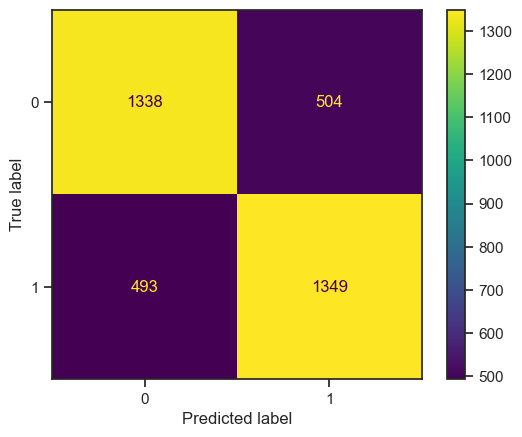

Results of K-nearest Neighbors
[0 1 0 ... 1 1 1]
Confusion Matrix : 
 [[1412  430]
 [ 208 1634]]
Accuracy :  0.8268186753528773
Specificity :  0.7665580890336591
Sensitivity :  0.8870792616720955
PPV :  0.7916666666666666
NPV :  0.8716049382716049
precision_score 0.7916666666666666
recall_score 0.8870792616720955
f1_score: 0.8366615463389657
AUC: 0.8268186753528772
Original ROC area: 0.827


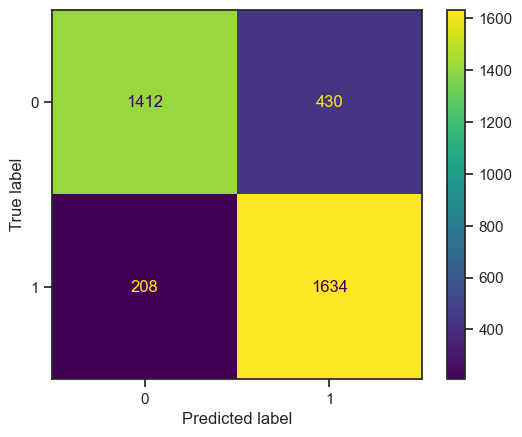

Results of Random Forest
[1 1 0 ... 1 0 0]
Confusion Matrix : 
 [[1068  774]
 [ 339 1503]]
Accuracy :  0.6978827361563518
Specificity :  0.5798045602605864
Sensitivity :  0.8159609120521173
PPV :  0.6600790513833992
NPV :  0.7590618336886994
precision_score 0.6600790513833992
recall_score 0.8159609120521173
f1_score: 0.7297887836853605
AUC: 0.6978827361563519
Original ROC area: 0.698


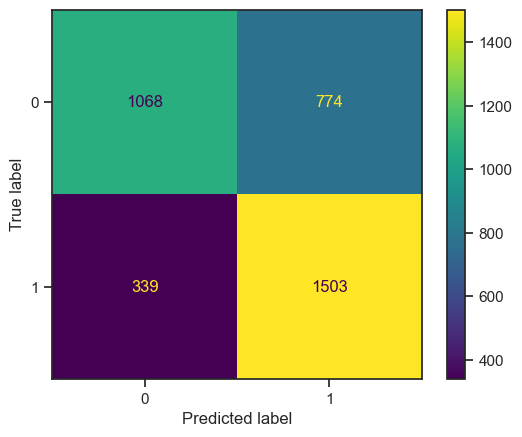

Results of Multilayer Perceptrons


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[1 1 0 ... 1 0 0]
Confusion Matrix : 
 [[1289  553]
 [ 450 1392]]
Accuracy :  0.7277415852334419
Specificity :  0.6997828447339848
Sensitivity :  0.755700325732899
PPV :  0.715681233933162
NPV :  0.7412305922944221
precision_score 0.715681233933162
recall_score 0.755700325732899
f1_score: 0.7351465540005281
AUC: 0.7277415852334418
Original ROC area: 0.728


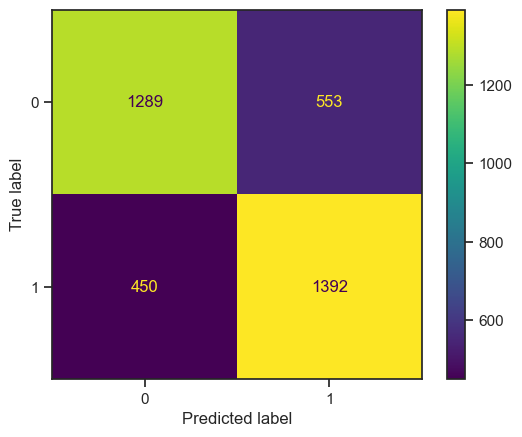

Results of Gradient Boosting Classifier
[1 1 1 ... 1 0 0]
Confusion Matrix : 
 [[1045  797]
 [ 499 1343]]
Accuracy :  0.6482084690553745
Specificity :  0.5673181324647123
Sensitivity :  0.7290988056460369
PPV :  0.6275700934579439
NPV :  0.6768134715025906
precision_score 0.6275700934579439
recall_score 0.7290988056460369
f1_score: 0.6745354093420391
AUC: 0.6482084690553747
Original ROC area: 0.648


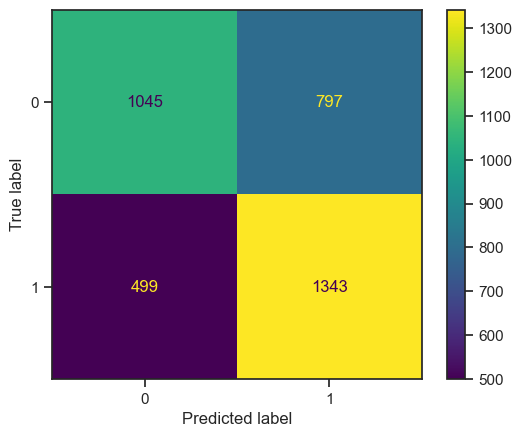

Results of Linear Support Vector Classifier


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopi

[1 1 0 ... 1 0 0]
Confusion Matrix : 
 [[1362  480]
 [ 541 1301]]
Accuracy :  0.7228555917480999
Specificity :  0.739413680781759
Sensitivity :  0.7062975027144408
PPV :  0.7304884896125772
NPV :  0.7157120336311088
precision_score 0.7304884896125772
recall_score 0.7062975027144408
f1_score: 0.718189345845984
AUC: 0.7228555917481
Original ROC area: 0.723


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


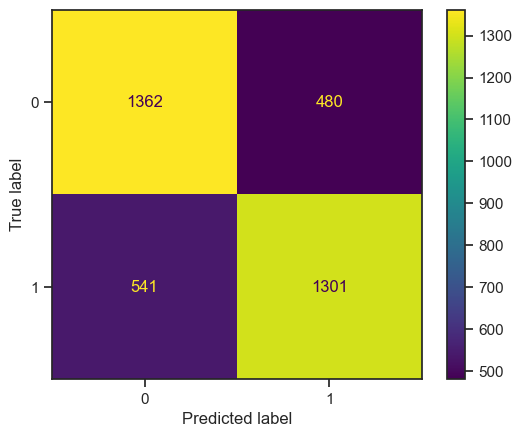

In [11]:
confunsion(logista_GS, "Logistic Regression")
confunsion(knn_GS, "K-nearest Neighbors")
confunsion(rng_forest_GS, "Random Forest")
confunsion(mlp_GS, "Multilayer Perceptrons")
confunsion(gbc_GS, "Gradient Boosting Classifier")
confunsion(svm_GS, "Linear Support Vector Classifier")

# Part 6: Model Calibration Plot - Internal Validation dataset

In [12]:
log_sigmoid = CalibratedClassifierCV(logista_GS, cv=10, method="sigmoid")
knn_sigmoid = CalibratedClassifierCV(knn_GS, cv=10, method="sigmoid")
rng_sigmoid = CalibratedClassifierCV(rng_forest_GS, cv=10, method="sigmoid")
mlp_sigmoid = CalibratedClassifierCV(mlp_GS, cv=10, method="sigmoid")
gbc_sigmoid = CalibratedClassifierCV(gbc_GS, cv=10, method="sigmoid")
svm_sigmoid = CalibratedClassifierCV(svm_GS, cv=10, method="sigmoid")

clf_list = [
    (log_sigmoid, "Logistic Regression"),
    (knn_sigmoid, "K-nearest Neighbors"),
    (rng_sigmoid, "Random Forest"),
    (mlp_sigmoid, "Multilayer Perceptron"),
    (gbc_sigmoid, "Gradient Boosting Classifier"),
    (svm_sigmoid, "Linear Support Vector Classifier")
    
]

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the

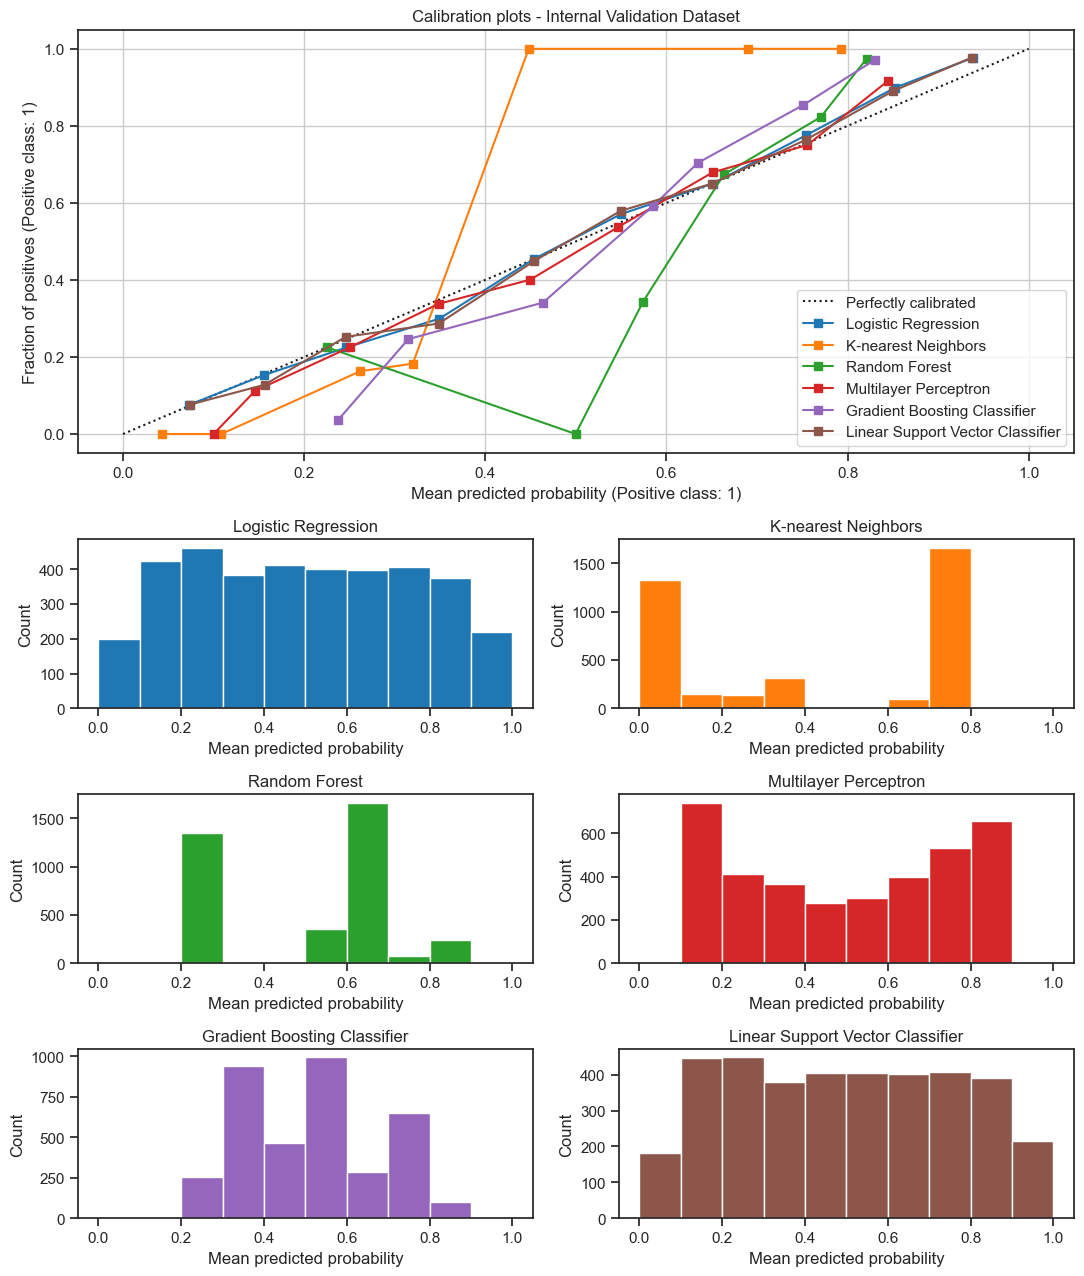

In [13]:
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("tab10")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X, y.ravel())
    display = CalibrationDisplay.from_estimator(
        clf,
        X,
        y,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots - Internal Validation Dataset")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1),(4,0), (4,1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Part 7: External Validation - Importing Data and pre-processing

In [14]:
# Importing Data
df2 = pd.read_excel("/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/Result/external_dataset.xlsx")
df2.info()
selected_features = ['age','sex','stat','HT','lipid','BMI','waistcir','calfcir','exhaustion']
df2.columns
df2 = df2.dropna(axis = 0, how = 'any')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  460 non-null    int64  
 1   Unnamed: 0    460 non-null    int64  
 2   age           460 non-null    float64
 3   sex           460 non-null    int64  
 4   stat          460 non-null    int64  
 5   edu           460 non-null    int64  
 6   DM            460 non-null    int64  
 7   HT            460 non-null    int64  
 8   Heart         460 non-null    int64  
 9   COPD          460 non-null    int64  
 10  Stroke        460 non-null    int64  
 11  lipid         460 non-null    int64  
 12  gouty         460 non-null    int64  
 13  CKD           460 non-null    int64  
 14  BMI           460 non-null    float64
 15  waistcir      460 non-null    float64
 16  calfcir       460 non-null    float64
 17  midarm        460 non-null    float64
 18  walktimemin   460 non-null    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         460 non-null    float64
 1   sex         460 non-null    int64  
 2   stat        460 non-null    int64  
 3   HT          460 non-null    int64  
 4   lipid       460 non-null    int64  
 5   BMI         460 non-null    float64
 6   waistcir    460 non-null    float64
 7   calfcir     460 non-null    float64
 8   exhaustion  460 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 32.5 KB


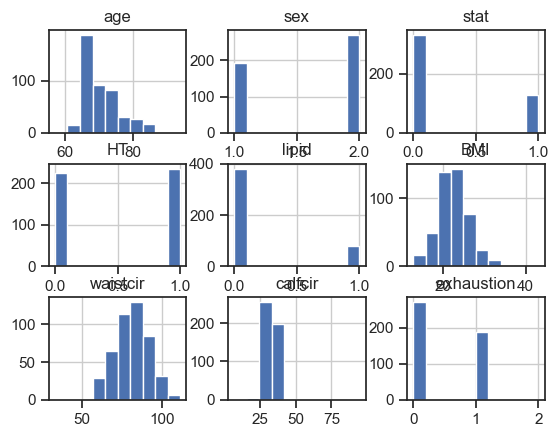

In [15]:
## X_test Feature Selection 
X = df2[selected_features]

X.info()
X.hist()
X = np.array(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   frail   460 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB


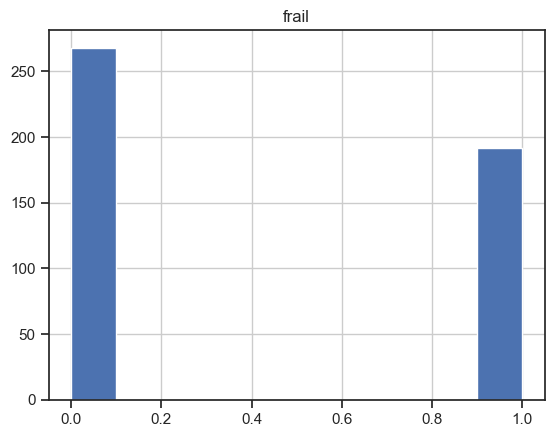

In [16]:
## Y Selection
y = df2[['frail']]
y.info()
y.hist()
y = np.array(y)

# Part 8: Confusion Matrix and Bootstrapping in External Validation dataset

Results of Logistic Regression
[0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1]
Confusion Matrix : 
 [[203  65]
 [ 

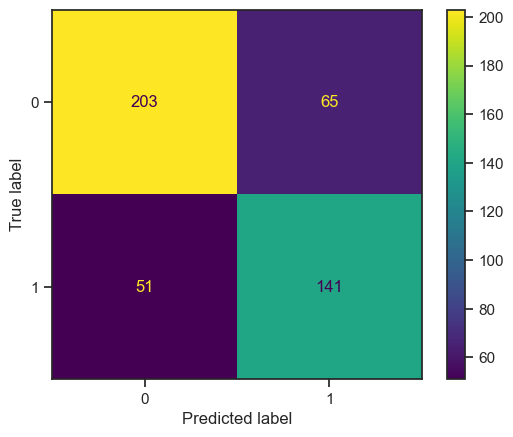

Results of K-nearest Neighbors
[0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1]
Confusion Matrix : 
 [[234  34]
 [1

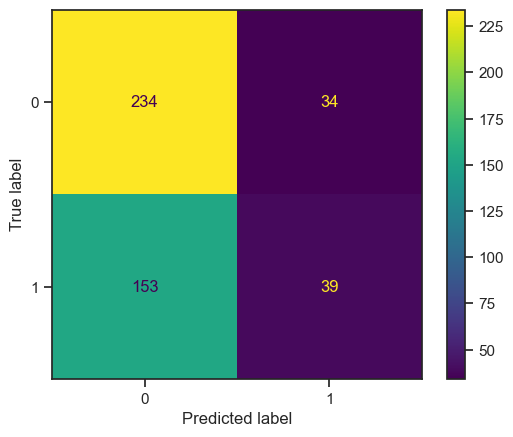

Results of Random Forest
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
Confusion Matrix : 
 [[208  60]
 [ 57 135

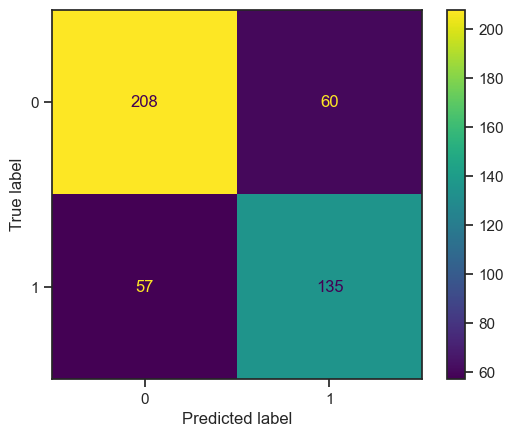

Results of Multilayer Perceptrons


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/ve

[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0
 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0
 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1
 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0
 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1]
Confusion Matrix : 
 [[210  58]
 [ 82 110]]
Accuracy :  0.69565217

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


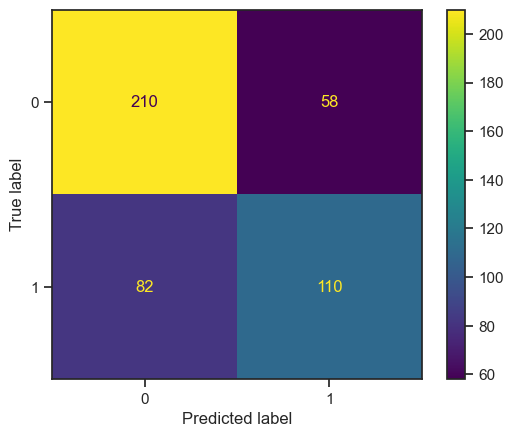

Results of Gradient Boosting Classifier
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Confusion Matrix : 
 [[260

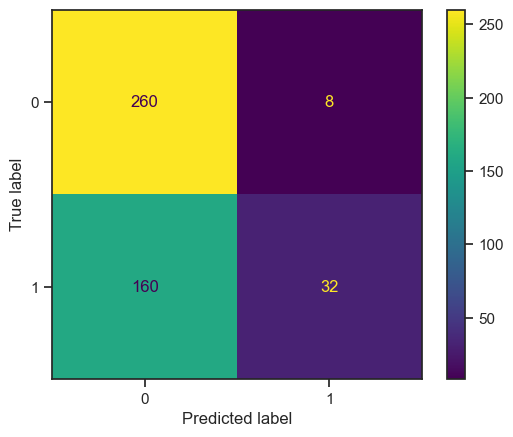

Results of Linear Support Vector Classifier


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopi

[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
Confusion Matrix : 
 [[210  58]
 [ 61 131]]
Accuracy :  0.74130434

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


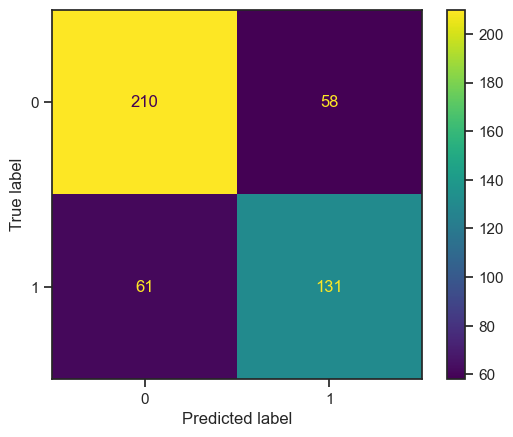

In [17]:
confunsion(logista_GS, "Logistic Regression")
confunsion(knn_GS, "K-nearest Neighbors")
confunsion(rng_forest_GS, "Random Forest")
confunsion(mlp_GS, "Multilayer Perceptrons")
confunsion(gbc_GS, "Gradient Boosting Classifier")
confunsion(svm_GS, "Linear Support Vector Classifier")

# Part 8 Model Validation using 1000 bootstrappings - External Validation

In [25]:
def bootstrap(model, model_name):
    y_pred = cross_val_predict(model, X, y.ravel(), cv = 10)
    print(y_pred)

    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y), len(y_pred))
        if len(np.unique(y[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
            
    plt.hist(bootstrapped_scores, bins=50)
    plt.title('Histogram of the bootstrapped ROC AUC scores - ' + str(model_name))
    plt.show()          

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))

[0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1]
Bootstrap #1 ROC area: 0.764
Bootstrap #2 ROC area: 0.741
Bootstra

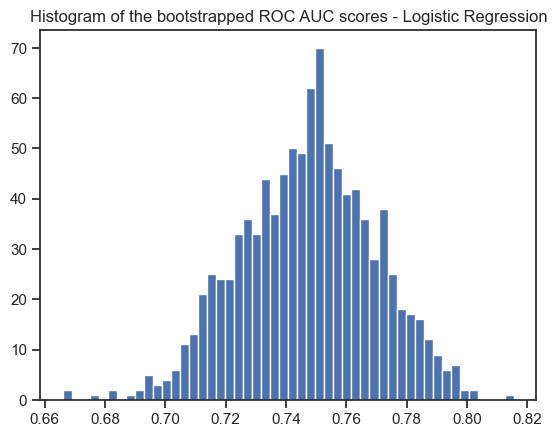

Confidence interval for the score: [0.711 - 0.783]
[0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1]
Bootstrap #1 RO

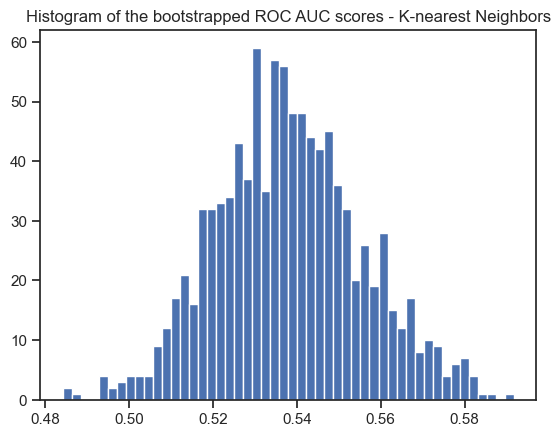

Confidence interval for the score: [0.511 - 0.569]
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
Bootstrap #1 RO

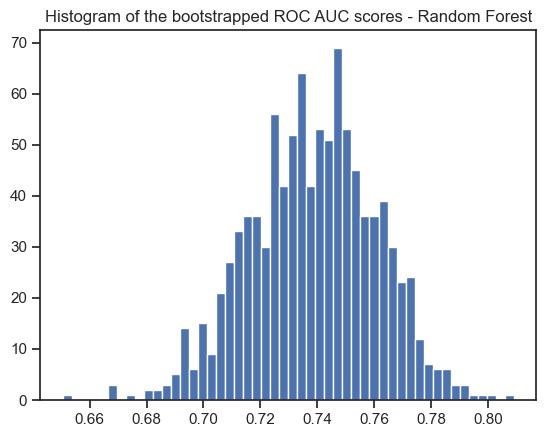

Confidence interval for the score: [0.701 - 0.772]


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/ve

[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0
 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1]
Bootstrap #1 ROC area: 0.710
Bootstrap #2 ROC area: 0.668
Bootstra

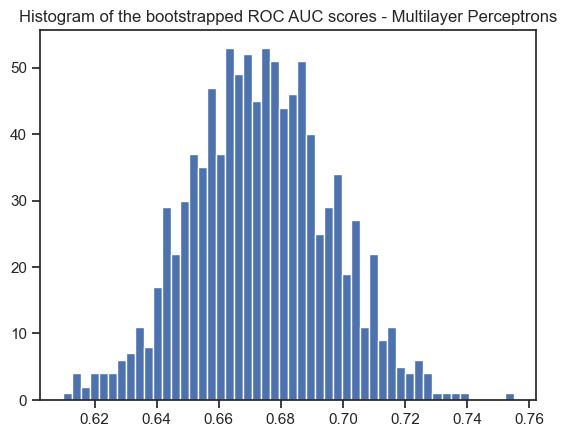

Confidence interval for the score: [0.638 - 0.71]
[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Bootstrap #1 ROC

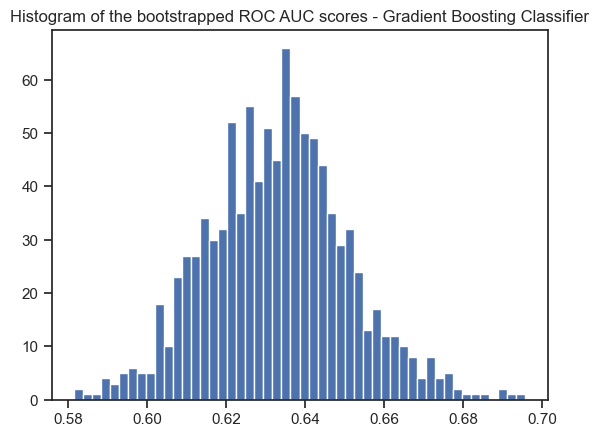

Confidence interval for the score: [0.604 - 0.663]


/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/natthanaphopi

[0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
Bootstrap #1 ROC area: 0.744
Bootstrap #2 ROC area: 0.720
Bootstra

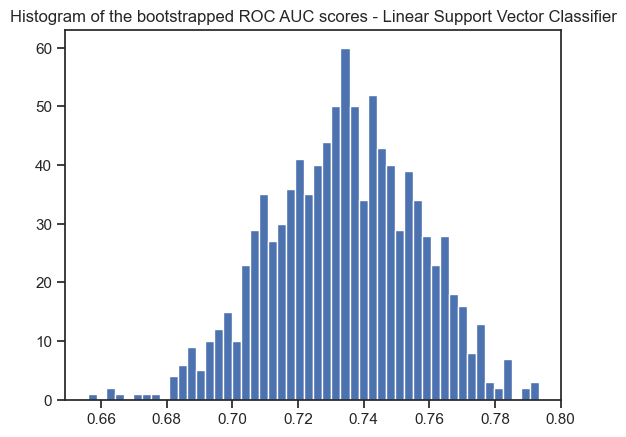

Confidence interval for the score: [0.696 - 0.769]


In [26]:
bootstrap(logista_GS, "Logistic Regression")
bootstrap(knn_GS, "K-nearest Neighbors")
bootstrap(rng_forest_GS, "Random Forest")
bootstrap(mlp_GS, "Multilayer Perceptrons")
bootstrap(gbc_GS, "Gradient Boosting Classifier")
bootstrap(svm_GS, "Linear Support Vector Classifier")

# Part 9: Model Calibration Plot - External Validation

/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/natthanaphopisaradech/Documents/Data_Hub/Frailty-Screening-and-surveillance/ve

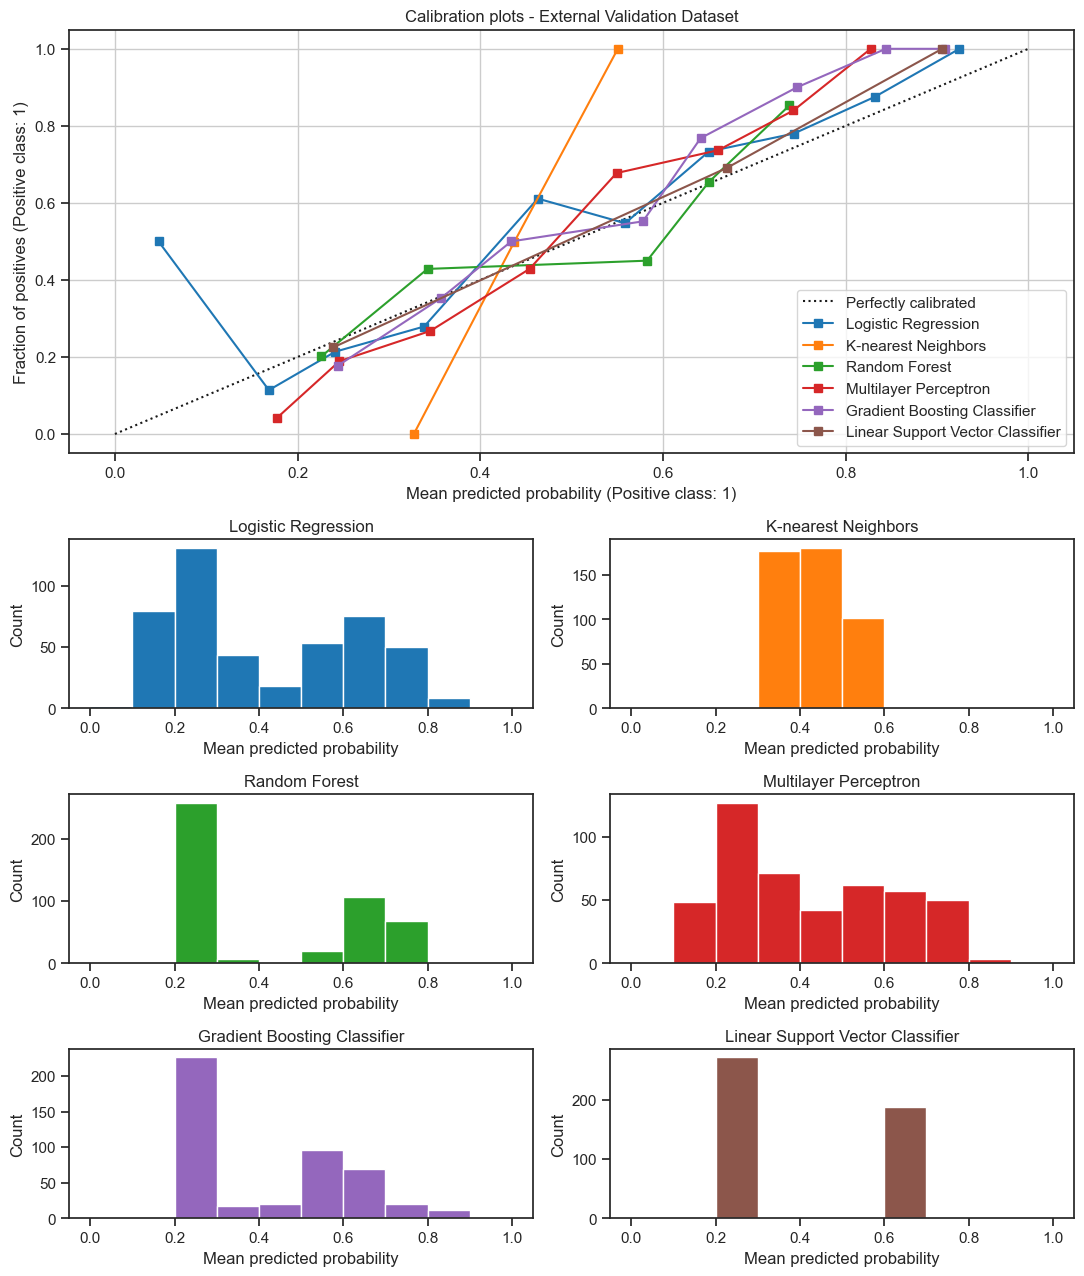

In [27]:
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("tab10")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X, y.ravel())
    display = CalibrationDisplay.from_estimator(
        clf,
        X,
        y,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots - External Validation Dataset")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1),(4,0), (4,1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()